## Time Series Forecasting with American Electric Power Consumption

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv("AEP_hourly.csv")
df.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [3]:
df = df.set_index('Datetime')

In [4]:
df.head()

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0


In [5]:
df.index = pd.to_datetime(df.index)

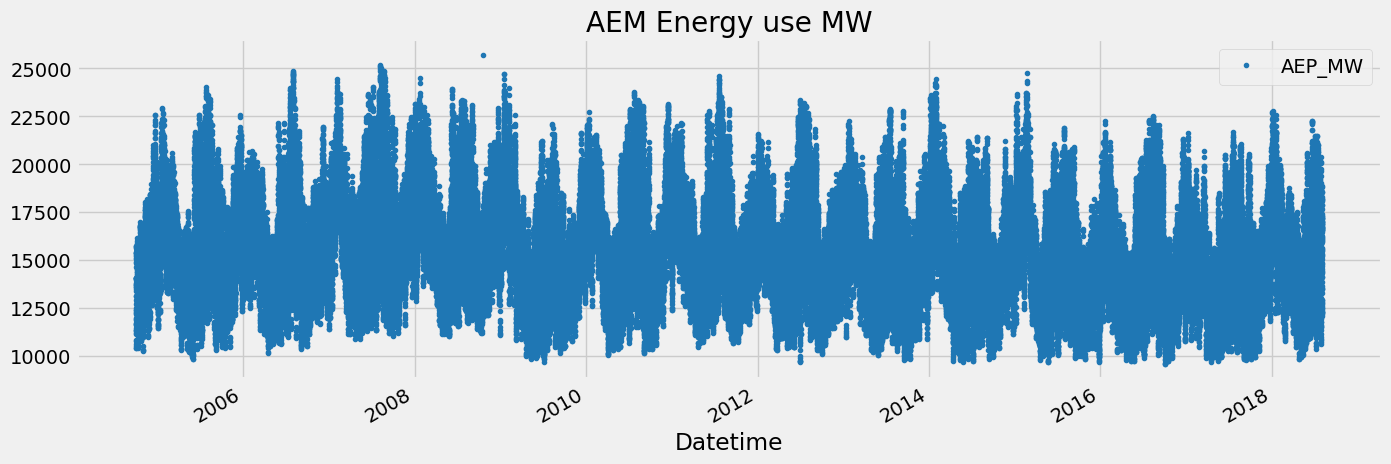

In [6]:
df.plot(style='.', figsize=(15, 5), color=color_pal[0], title='AEM Energy use MW')
plt.show()

In [7]:
df.index

DatetimeIndex(['2004-12-31 01:00:00', '2004-12-31 02:00:00',
               '2004-12-31 03:00:00', '2004-12-31 04:00:00',
               '2004-12-31 05:00:00', '2004-12-31 06:00:00',
               '2004-12-31 07:00:00', '2004-12-31 08:00:00',
               '2004-12-31 09:00:00', '2004-12-31 10:00:00',
               ...
               '2018-01-01 15:00:00', '2018-01-01 16:00:00',
               '2018-01-01 17:00:00', '2018-01-01 18:00:00',
               '2018-01-01 19:00:00', '2018-01-01 20:00:00',
               '2018-01-01 21:00:00', '2018-01-01 22:00:00',
               '2018-01-01 23:00:00', '2018-01-02 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=121273, freq=None)

## Train/Test Split

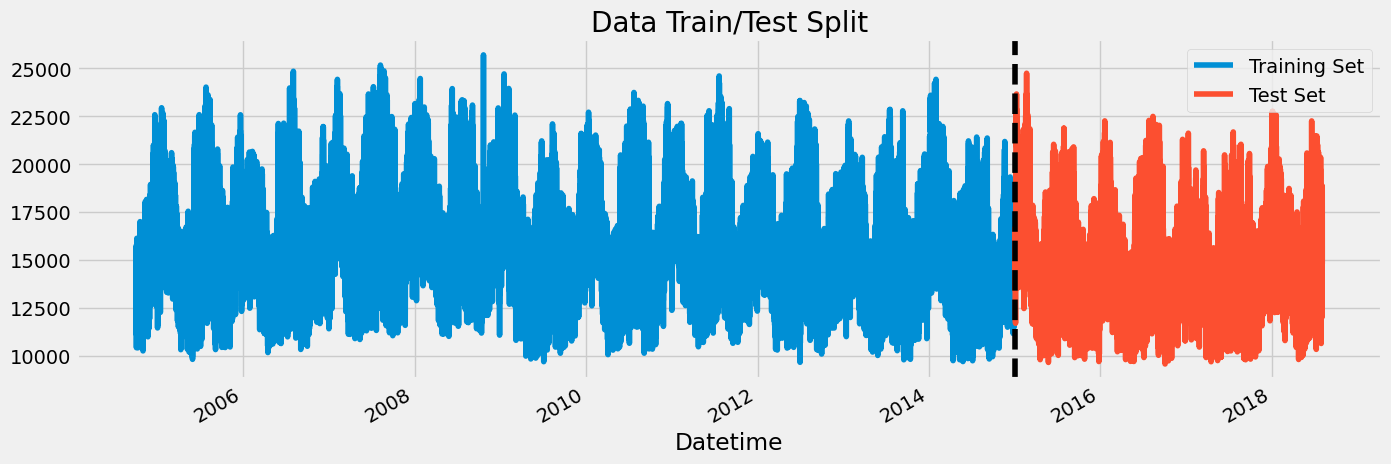

In [8]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

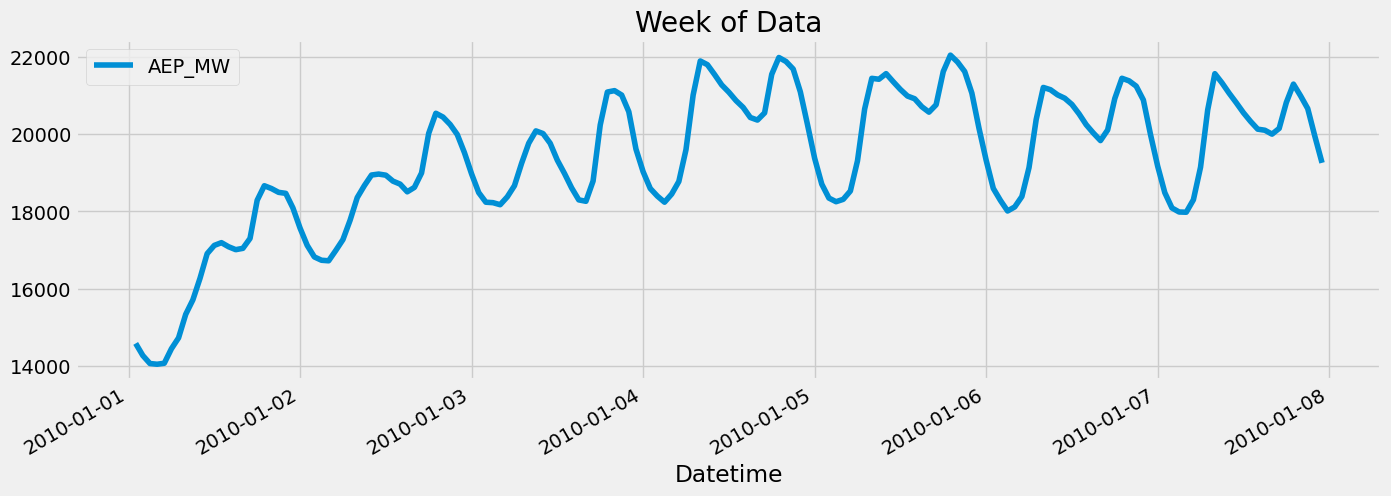

In [9]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')].plot(figsize=(15,5), title='Week of Data')
plt.show()

## Create Features

In [10]:
def create_features(df):
    """
    Create time series features basd on time series index
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

In [11]:
df = create_features(df)

In [12]:
df.head()

,AEP_MW,hour,dayofweek,quarter,month,year,dayofyear
Datetime,,,,,,,
2004-12-31 01:00:00,13478.0,1,4,4,12,2004,366
2004-12-31 02:00:00,12865.0,2,4,4,12,2004,366
2004-12-31 03:00:00,12577.0,3,4,4,12,2004,366
2004-12-31 04:00:00,12517.0,4,4,4,12,2004,366
2004-12-31 05:00:00,12670.0,5,4,4,12,2004,366


## Visualize our Feature / Target Relationship

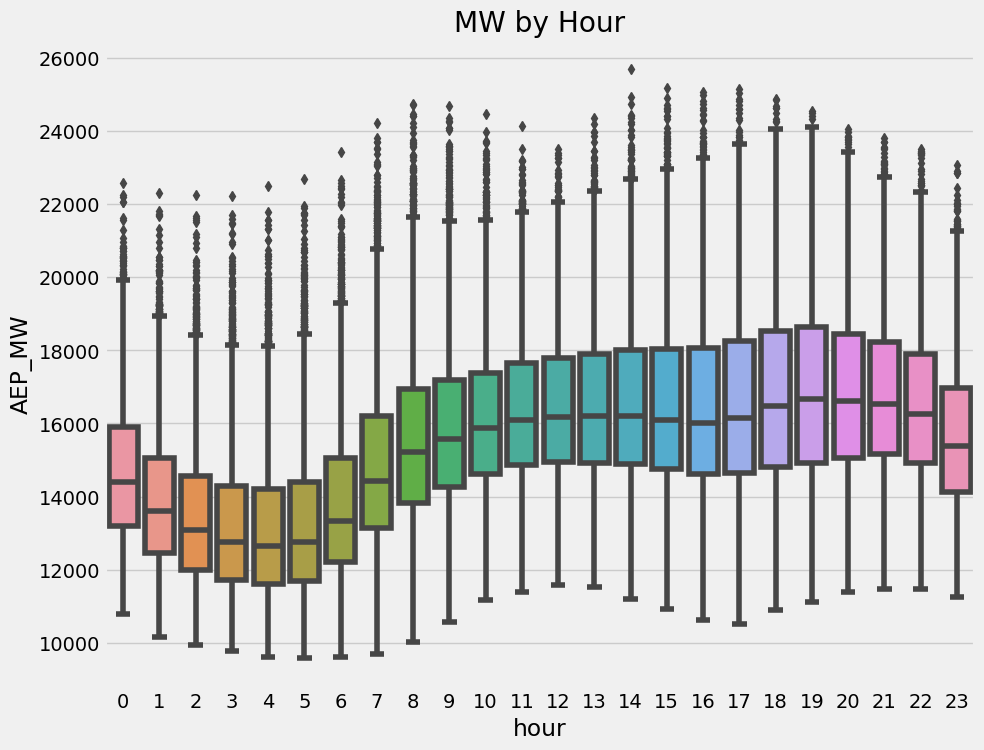

In [13]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x='hour', y='AEP_MW')
ax.set_title('MW by Hour')
plt.show()

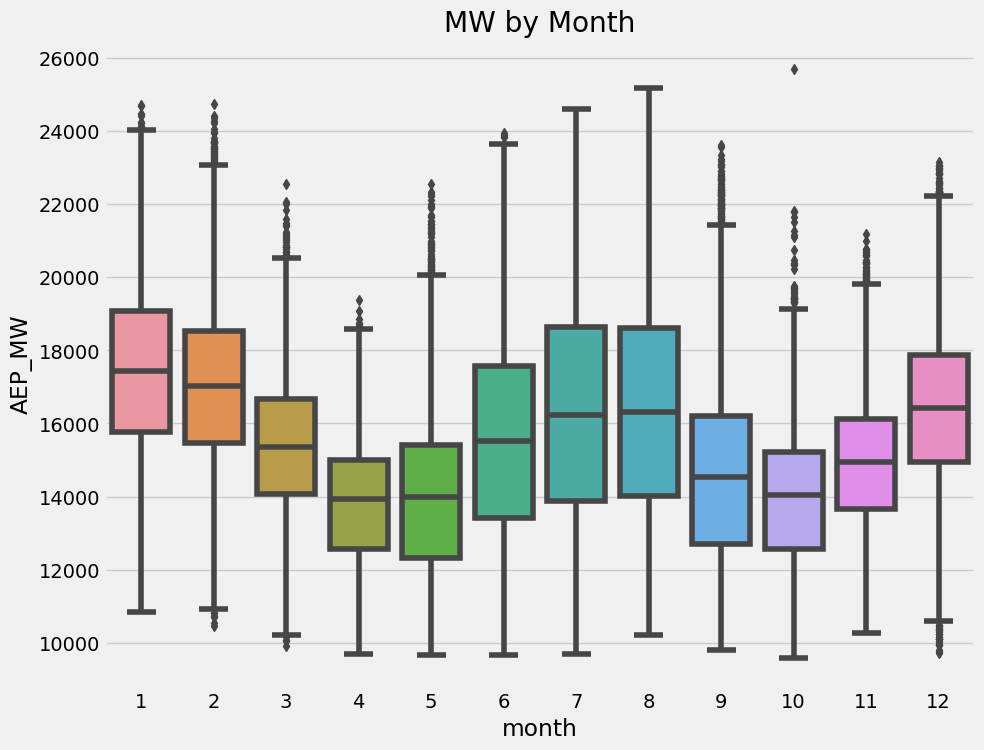

In [14]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x='month', y='AEP_MW')
ax.set_title('MW by Month')
plt.show()

## Create our Model

In [15]:
train = create_features(train)
test = create_features(test)

FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']
TARGET = 'AEP_MW'

In [16]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [17]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50,
                       learning_rate=0.01)

reg.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:15792.50936	validation_1-rmse:14861.30366
[100]	validation_0-rmse:5946.76890	validation_1-rmse:5177.35119
[200]	validation_0-rmse:2508.95368	validation_1-rmse:2124.36626
[300]	validation_0-rmse:1472.70614	validation_1-rmse:1577.19471
[382]	validation_0-rmse:1226.48428	validation_1-rmse:1578.89350


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

## Feature Importance

In [18]:
fi = pd.DataFrame(data=reg.feature_importances_,
            index=reg.feature_names_in_,
            columns=['importance'])

In [19]:
fi

,importance
hour,0.431384
dayofweek,0.188986
quarter,0.018132
month,0.177474
year,0.051083
dayofyear,0.132941


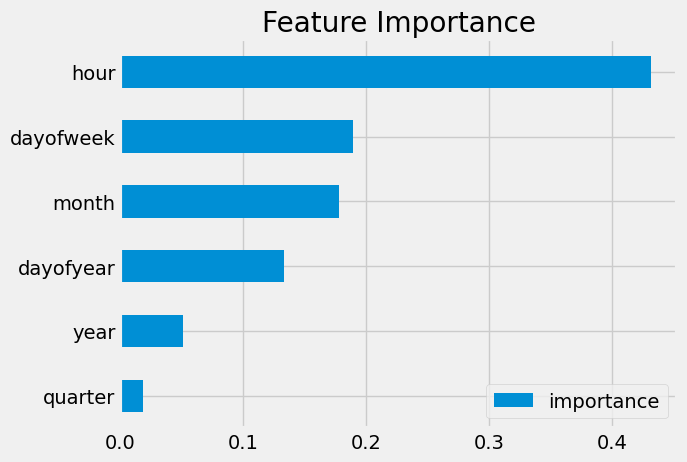

In [20]:
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

## Forescast on Test

In [21]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

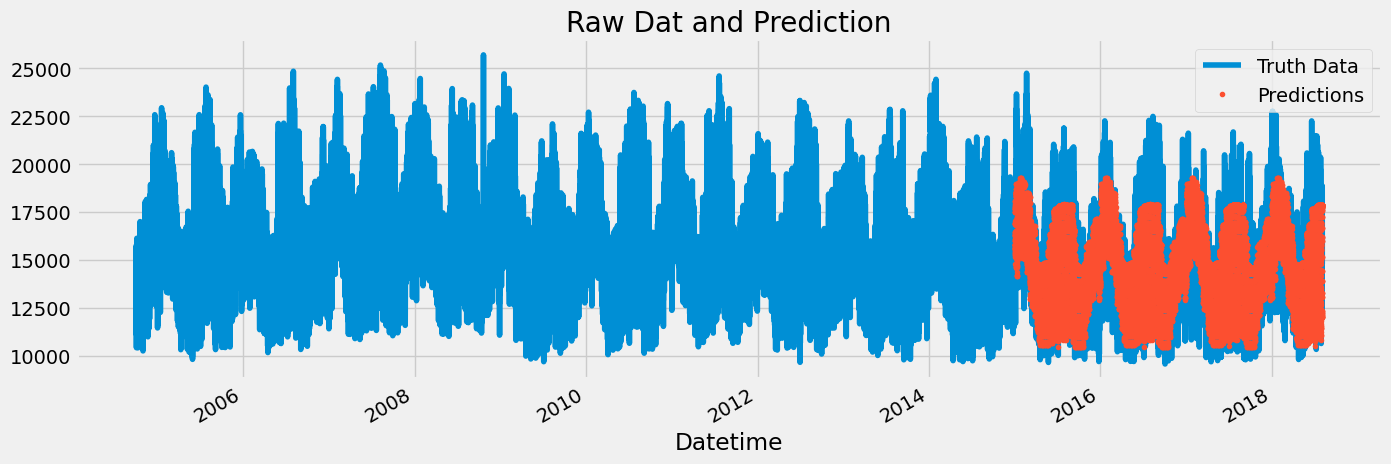

In [22]:
ax = df[['AEP_MW']].plot(figsize=(15,5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

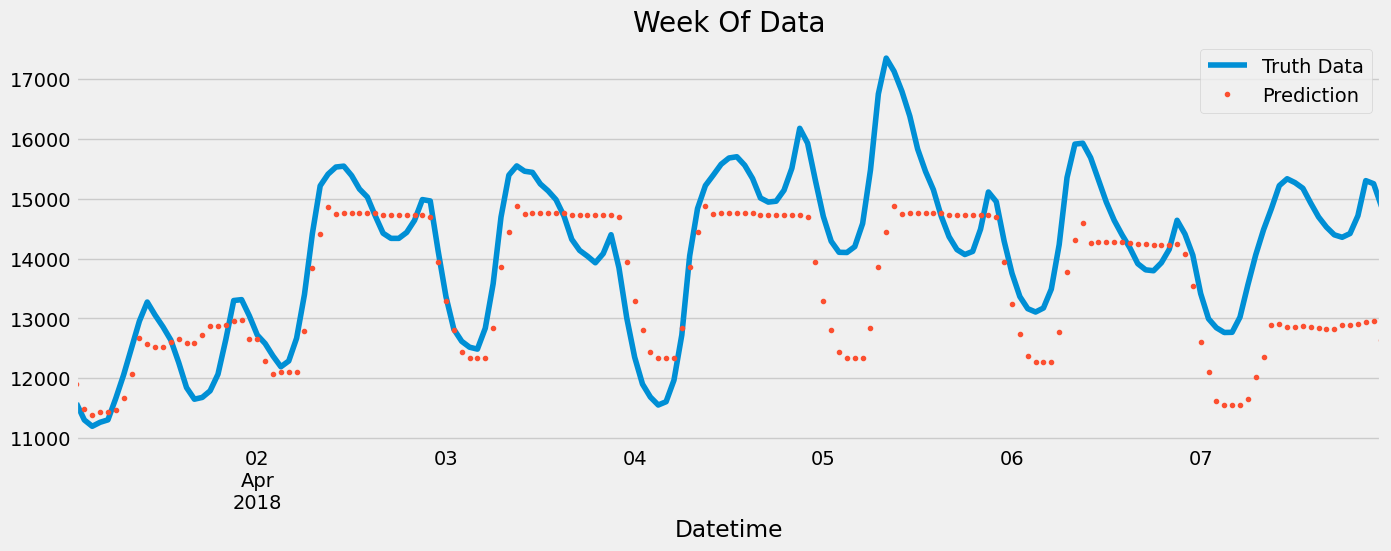

In [24]:
ax  = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['AEP_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data', 'Prediction'])
plt.show()

In [26]:
score = np.sqrt(mean_squared_error(test['AEP_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 1563.38


# Calculate Error

- Look at the worst and best predicted days

In [32]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(5)

date
2015-02-20    5461.675130
2015-02-19    5360.712606
2018-01-06    5083.077718
2018-01-07    4693.319539
2015-02-16    4321.795817
Name: error, dtype: float64

In [54]:
test.groupby(['date'])['error'].mean().sort_values(ascending=True).head(5)

date
2015-09-26    207.230632
2017-05-21    210.977254
2017-11-16    213.768026
2017-10-12    220.800659
2016-06-05    222.770793
Name: error, dtype: float64

# Next Steps

- More robust crosss validation
- Add more features (weather forecast, holidays)

# Outline.
- Outlier analysis.
- Forecasting horizon explained.
- Time series cross validation.
- Lag Features
- Predicting the Future

In [150]:
df = pd.read_csv("AEP_hourly.csv")
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)
df.head()

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0


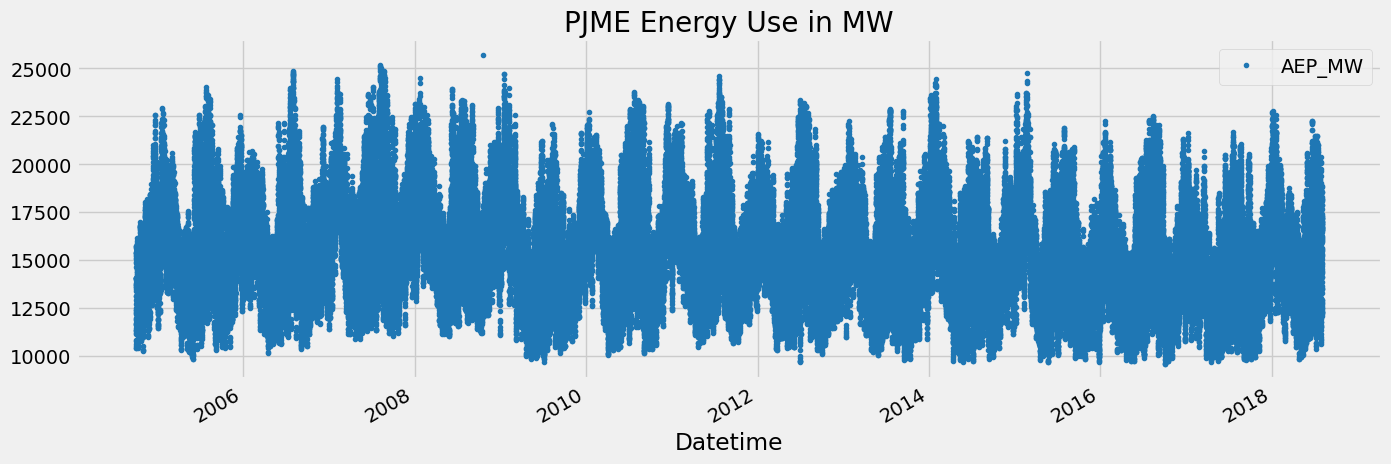

In [151]:
df.plot(style='.',
       figsize=(15,5),
       color=color_pal[0],
       title='PJME Energy Use in MW')
plt.show()

# 1. Outlier Analysis and removal

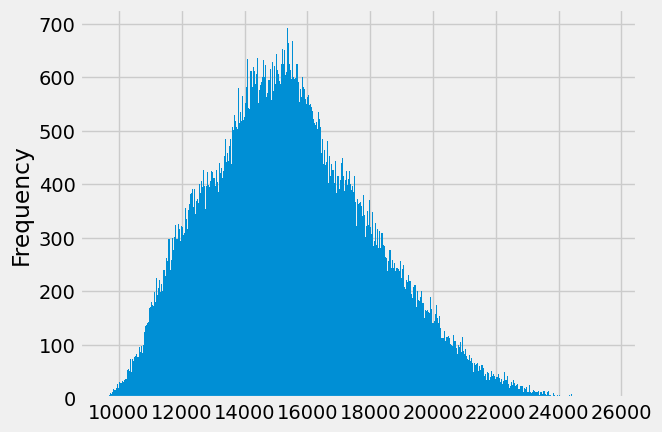

In [153]:
df['AEP_MW'].plot(kind='hist', bins=500)
plt.show()

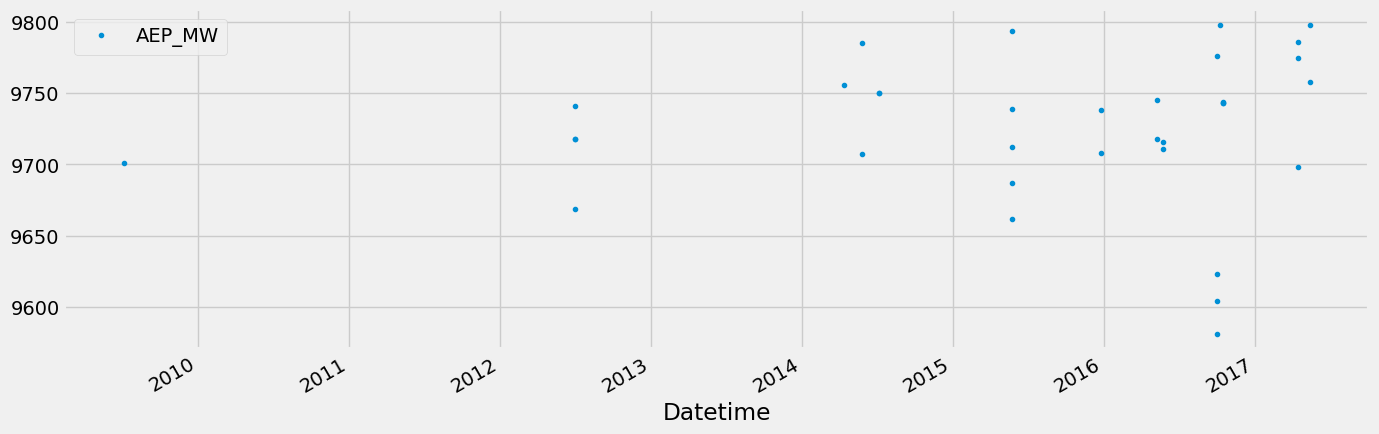

In [154]:
df.query('AEP_MW < 9800').plot(figsize=(15,5), style='.')
plt.show()

In [155]:
df = df.query('AEP_MW > 9800').copy()

# Reviewing: Train/Test Split

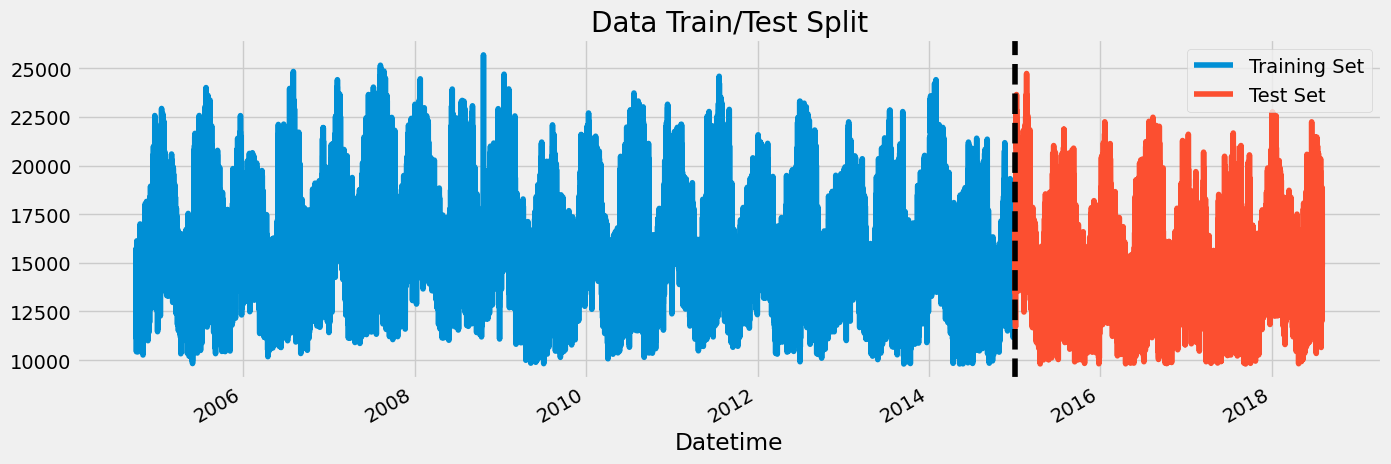

In [156]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label='Testing Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

# 1. Time Series Cross Validation

In [157]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

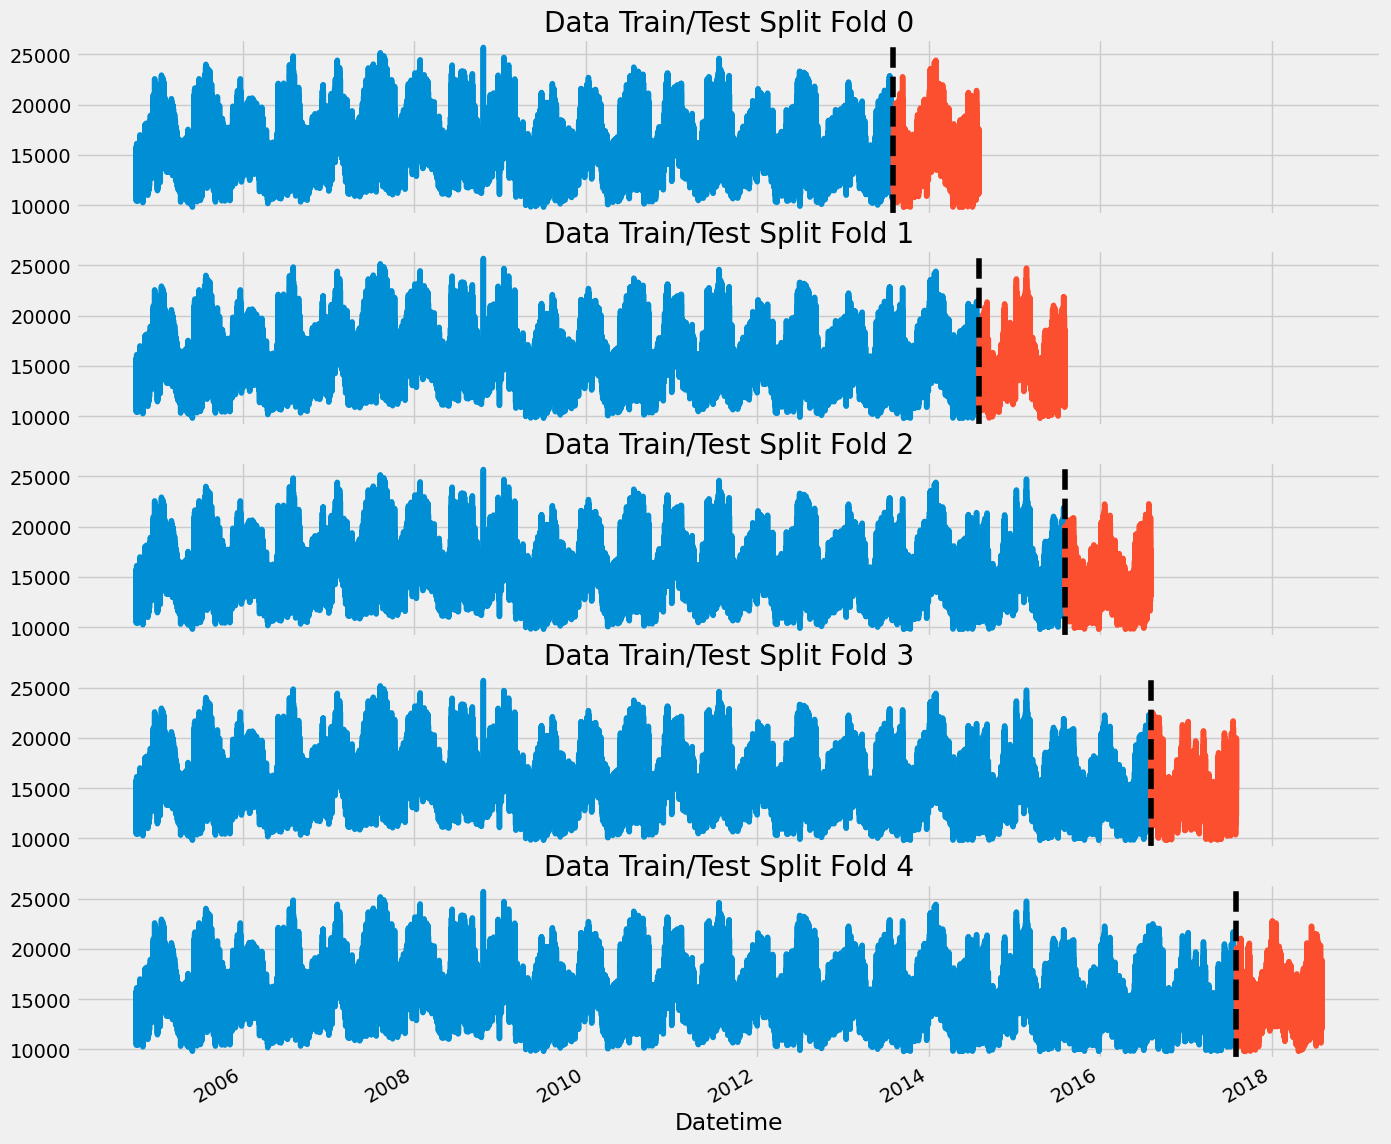

In [158]:
fig, axs = plt.subplots(5, 1, figsize=(15,15),
                            sharex=True)
fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['AEP_MW'].plot(ax=axs[fold],
                        label='Training Set',
                        title=f'Data Train/Test Split Fold {fold}')
    test['AEP_MW'].plot(ax=axs[fold], 
                        label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1

# 2. Forecasting Horizon Explained

The forecast horizon is the lenght of time into the future for which forecasts are to be prepared. These generally vary from short-term forecasting horizons (less than three months) to long-term horizons (more than two years).

In [159]:
df = create_features(df)
df.head()

,AEP_MW,hour,dayofweek,quarter,month,year,dayofyear
Datetime,,,,,,,
2004-10-01 01:00:00,12379.0,1,4,4,10,2004,275
2004-10-01 02:00:00,11935.0,2,4,4,10,2004,275
2004-10-01 03:00:00,11692.0,3,4,4,10,2004,275
2004-10-01 04:00:00,11597.0,4,4,4,10,2004,275
2004-10-01 05:00:00,11681.0,5,4,4,10,2004,275


# 3. Lag Features
- What was the target (x) days in the past.

In [160]:
def add_lags(df):
    target_map = df['AEP_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [161]:
df = add_lags(df)
df.head()

,AEP_MW,hour,dayofweek,quarter,month,year,dayofyear,lag1,lag2,lag3
Datetime,,,,,,,,,,
2004-10-01 01:00:00,12379.0,1,4,4,10,2004,275,NaN,NaN,NaN
2004-10-01 02:00:00,11935.0,2,4,4,10,2004,275,NaN,NaN,NaN
2004-10-01 03:00:00,11692.0,3,4,4,10,2004,275,NaN,NaN,NaN
2004-10-01 04:00:00,11597.0,4,4,4,10,2004,275,NaN,NaN,NaN
2004-10-01 05:00:00,11681.0,5,4,4,10,2004,275,NaN,NaN,NaN


# Train Using Cross Validation

In [163]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    train = create_features(train)
    test = create_features(test)
    
    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year', 
                'lag1', 'lag2', 'lag3']
    TARGET = 'AEP_MW'
    
    X_train = train[FEATURES]
    y_train = train[TARGET]
    
    X_test = test[FEATURES]
    y_test = test[TARGET]
    
    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                          n_estimators=1000,
                          early_stopping_rounds=50,
                          objective='reg:linear',
                          max_depth=3,
                          learning_rate=0.01)
    reg.fit(X_train, y_train,
           eval_set=[(X_train, y_train),(X_test, y_test)],
           verbose=100)
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test,y_pred))
    scores.append(score)

[15:13:18] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:15898.80812	validation_1-rmse:15268.75051
[100]	validation_0-rmse:6031.12091	validation_1-rmse:5643.40165
[200]	validation_0-rmse:2654.18213	validation_1-rmse:2426.78522
[300]	validation_0-rmse:1708.72415	validation_1-rmse:1643.72309
[400]	validation_0-rmse:1490.42962	validation_1-rmse:1554.67235
[458]	validation_0-rmse:1448.71076	validation_1-rmse:1557.73919
[15:13:31] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:15836.66291	validation_1-rmse:15215.35051
[100]	validation_0-rmse:6008.17777	validation_1-rmse:5712.71045
[200]	validation_0-rmse:26

In [164]:
scores

[1553.61538419081,
 1425.5638252934907,
 1497.5968559807889,
 1649.7640995414022,
 1696.9580184840743]

In [165]:
print(f'Score across folds {np.mean(scores): 0.4f}')
print(f'Fold scores: {scores}')

Score across folds  1564.6996
Fold scores: [1553.61538419081, 1425.5638252934907, 1497.5968559807889, 1649.7640995414022, 1696.9580184840743]


# 4. Predicting the Future

- Retraining on all data
- To Predict the future we need an empty dataframe for future date ranges.
- Run those dates through our feature creation code + lag creation

In [168]:
# Retrain on all data
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year', 
            'lag1', 'lag2', 'lag3']
TARGET = 'AEP_MW'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                      booster='gbtree',
                      n_estimators=500,
                      objective='reg:linear',
                      max_depth=3,
                      learning_rate=0.01)
reg.fit(X_all, y_all,
       eval_set=[(X_all, y_all)],
       verbose=100)

[15:31:08] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:15560.35919
[100]	validation_0-rmse:5909.17638
[200]	validation_0-rmse:2622.47826
[300]	validation_0-rmse:1721.81825
[400]	validation_0-rmse:1523.52245
[499]	validation_0-rmse:1472.30460


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [170]:
# Create future dataframe
future = pd.date_range('2018-08-03', '2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [171]:
df_and_future

,AEP_MW,hour,dayofweek,quarter,month,year,dayofyear,lag1,lag2,lag3,isFuture
2004-10-01 01:00:00,12379.0,1,4,4,10,2004,275,NaN,NaN,NaN,False
2004-10-01 02:00:00,11935.0,2,4,4,10,2004,275,NaN,NaN,NaN,False
2004-10-01 03:00:00,11692.0,3,4,4,10,2004,275,NaN,NaN,NaN,False
2004-10-01 04:00:00,11597.0,4,4,4,10,2004,275,NaN,NaN,NaN,False
2004-10-01 05:00:00,11681.0,5,4,4,10,2004,275,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,NaN,20,2,3,7,2019,212,16579.0,18495.0,20026.0,True
2019-07-31 21:00:00,NaN,21,2,3,7,2019,212,16457.0,17771.0,19529.0,True
2019-07-31 22:00:00,NaN,22,2,3,7,2019,212,16197.0,17220.0,19029.0,True
2019-07-31 23:00:00,NaN,23,2,3,7,2019,212,15259.0,16100.0,17790.0,True


In [172]:
future_w_features = df_and_future.query('isFuture').copy()

In [173]:
future_w_features

,AEP_MW,hour,dayofweek,quarter,month,year,dayofyear,lag1,lag2,lag3,isFuture
2018-08-03 00:00:00,NaN,0,4,3,8,2018,215,15045.0,16491.0,13669.0,True
2018-08-03 01:00:00,NaN,1,4,3,8,2018,215,13940.0,15319.0,12772.0,True
2018-08-03 02:00:00,NaN,2,4,3,8,2018,215,13230.0,14492.0,12253.0,True
2018-08-03 03:00:00,NaN,3,4,3,8,2018,215,12624.0,13945.0,11928.0,True
2018-08-03 04:00:00,NaN,4,4,3,8,2018,215,12410.0,13619.0,11696.0,True
...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,NaN,20,2,3,7,2019,212,16579.0,18495.0,20026.0,True
2019-07-31 21:00:00,NaN,21,2,3,7,2019,212,16457.0,17771.0,19529.0,True
2019-07-31 22:00:00,NaN,22,2,3,7,2019,212,16197.0,17220.0,19029.0,True
2019-07-31 23:00:00,NaN,23,2,3,7,2019,212,15259.0,16100.0,17790.0,True


# Predict the Future

In [174]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

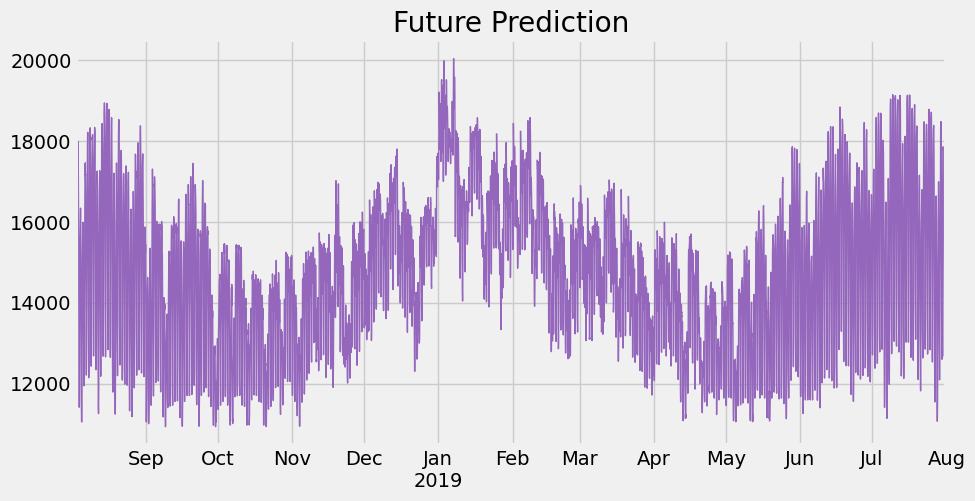

In [176]:
future_w_features['pred'].plot(figsize=(10,5),
                              color=color_pal[4],
                              ms=1, lw=1, title='Future Prediction')
plt.show()

# Bonus: Saving Model For Later

In [181]:
# Save model
reg.save_model('model.json')

In [ ]:
reg_new = xgb.XGBRegressor()
reg_new.load_model('model.json')
future_w_features['pred'] = reg_new.predict(future_w_features[FEATURES])
future_w_features['pred'].plot(figsize=(10, 5),
                              color=color_pal[4],
                              ms=1, lw=1,
                              title='Future P')